In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def compute_daily_yield(data):
    if data.empty:
        return pd.Series(dtype=float)
    total_orig = data.groupby("LoanID")["OriginatedAmount"].first().sum()
    daily_paid = data.groupby("Days_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()
    return daily_paid / total_orig

In [3]:
latest = pd.read_csv("/Users/starsrain/2025_concord/yieldCurve_augmenting/raw_data/yieldcurvedata_1007.csv")
july = pd.read_csv("/Users/starsrain/2025_concord/yieldCurve_augmenting/raw_data/yieldcurvedata_730.csv")
august = pd.read_csv("/Users/starsrain/2025_concord/yieldCurve_augmenting/raw_data/yieldcurvedata_820.csv")

In [7]:

print(latest.shape)
print(latest.columns)
print(latest.dtypes)
print(latest.isnull().sum())
print(latest.describe())
print(latest.info())


(754335, 25)
Index(['Application_ID', 'PortFolioID', 'LoanID', 'Frequency', 'LPCampaign',
       'OriginatedAmount', 'OrigYear', 'OrigMonth', 'OrigWeek',
       'OriginationDate', 'FPDFA', 'FPDAA', 'TotalRealizedPayin',
       'InstallmentNumber', 'PaidOffPaymentAmount', 'TransactionDate',
       'PmtYear', 'PmtMonth', 'Days_Since_Orig', 'Weeks_Since_Orig',
       'PaymentType', 'Payment_Number', 'PaymentStatus',
       'weeks_between_orig_now', 'CustType'],
      dtype='object')
Application_ID              int64
PortFolioID                 int64
LoanID                     object
Frequency                  object
LPCampaign                 object
OriginatedAmount          float64
OrigYear                  float64
OrigMonth                 float64
OrigWeek                  float64
OriginationDate            object
FPDFA                     float64
FPDAA                     float64
TotalRealizedPayin        float64
InstallmentNumber           int64
PaidOffPaymentAmount      float64
Trans

In [4]:
def preprocess_data(df, name):
    """Preprocess yield curve data"""
    df = df.copy()
    df["OriginationDate"] = pd.to_datetime(df["OriginationDate"])
    df = df.dropna(subset=["Days_Since_Orig", "OriginatedAmount", "PaidOffPaymentAmount", "Frequency"])
    df = df[df["PaymentStatus"] == "D"] # paid off customers
    df["Days_Since_Orig"] = df["Days_Since_Orig"].astype(int)
    df["OrigMonth"] = df["OriginationDate"].dt.to_period("M")
    print(f"{name} data: {len(df)} records, {df['LoanID'].nunique()} unique loans")
    return df

latest = preprocess_data(latest, "Latest")
july = preprocess_data(july, "July") 
august = preprocess_data(august, "August")

Latest data: 437613 records, 92958 unique loans
July data: 388277 records, 83927 unique loans
August data: 404144 records, 87045 unique loans


In [5]:
latest[['InstallmentNumber','Frequency','FPDFA', 'FPDAA']].head(10)

,InstallmentNumber,Frequency,FPDFA,FPDAA
1,1,B,1.0,0.0
2,2,B,1.0,0.0
3,3,B,1.0,0.0
4,4,B,1.0,0.0
6,5,B,1.0,0.0
7,6,B,1.0,0.0
8,7,B,1.0,0.0
9,1,B,0.0,0.0
10,2,B,0.0,0.0
11,3,B,0.0,0.0


In [ ]:
# investigate installment number (summarizing stats + quick plotting)
print(latest['InstallmentNumber'].max())

146


Installment summary by Frequency (per-loan Kmax):


,Frequency,loans_x,k_min,k_mean,k_median,k_p25,k_p75,k_p95,k_p99,k_max,rows,loans_y,loans_gt10,loans_gt20,loans_gt40
0,B,64336,1,4.595499,3.0,1.0,6.0,16.0,19.0,105,300371,64336,7759,176,27
1,MB,9154,1,3.265785,2.0,1.0,4.0,11.0,16.0,32,31320,9154,504,4,0
2,ME,6036,1,3.033135,1.0,1.0,4.0,10.0,16.0,65,19081,6036,294,8,4
3,W,13432,1,6.520473,5.0,2.0,10.0,18.0,20.0,146,86841,13432,2983,106,15


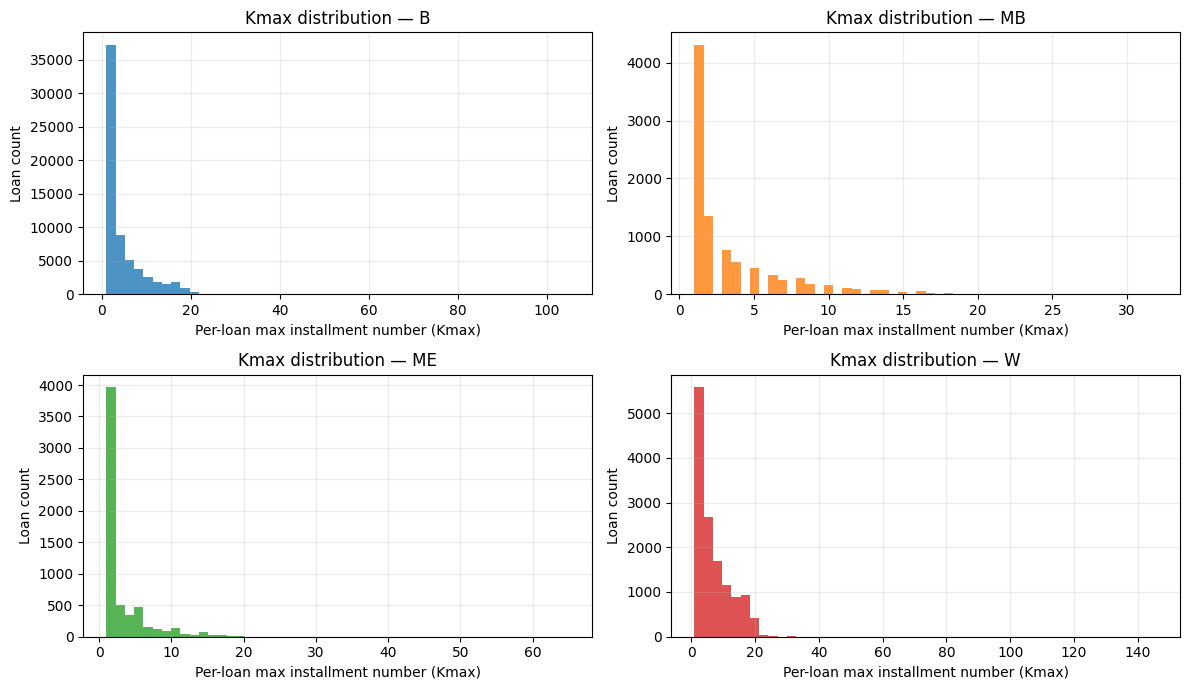

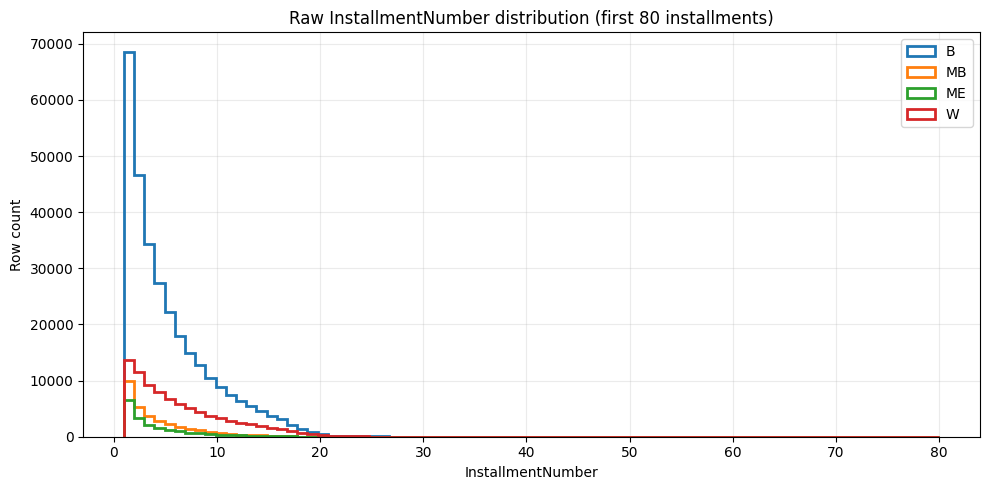

In [12]:
# Summarize installment numbers by Frequency and plot distributions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use preprocessed latest dataset
dfi = latest.copy()

# Basic counts by frequency
rows_by_freq = dfi.groupby("Frequency", as_index=False).size().rename(columns={"size":"rows"})
loans_by_freq = (dfi.groupby(["Frequency","LoanID"], as_index=False)
                   .size()
                   .groupby("Frequency", as_index=False)
                   .size()
                   .rename(columns={"size":"loans"}))

# Per-loan max installment number (Kmax)
per_loan_kmax = (dfi.groupby(["Frequency","LoanID"], as_index=False)
                   .agg(Kmax=("InstallmentNumber","max")))

# Summary stats per frequency (no groupby.apply to avoid FutureWarning)
_summary = (per_loan_kmax.groupby("Frequency")
             .agg(
                 loans=("LoanID","nunique"),
                 k_min=("Kmax","min"),
                 k_mean=("Kmax","mean"),
                 k_median=("Kmax","median"),
                 k_p25=("Kmax", lambda s: float(s.quantile(0.25))),
                 k_p75=("Kmax", lambda s: float(s.quantile(0.75))),
                 k_p95=("Kmax", lambda s: float(s.quantile(0.95))),
                 k_p99=("Kmax", lambda s: float(s.quantile(0.99))),
                 k_max=("Kmax","max"),
             )
             .reset_index())

# Add how many loans exceed some thresholds
_thresh = (per_loan_kmax.assign(
                gt10=lambda d: d["Kmax"] > 10,
                gt20=lambda d: d["Kmax"] > 20,
                gt40=lambda d: d["Kmax"] > 40,
            )
            .groupby("Frequency", as_index=False)
            .agg(
                loans_gt10=("gt10","sum"),
                loans_gt20=("gt20","sum"),
                loans_gt40=("gt40","sum"),
            ))

summary = (_summary.merge(rows_by_freq, on="Frequency", how="left")
                    .merge(loans_by_freq, on="Frequency", how="left")
                    .merge(_thresh, on="Frequency", how="left")
                    .sort_values("Frequency"))

print("Installment summary by Frequency (per-loan Kmax):")
display(summary)

# -------------------- Plots --------------------
# 1) Per-loan Kmax distributions (small multiples)
freqs = sorted(per_loan_kmax["Frequency"].unique())
cols = 2
rows = int(np.ceil(len(freqs)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(12, 3.5*rows), squeeze=False)

for i, f in enumerate(freqs):
    ax = axes[i//cols, i%cols]
    data = per_loan_kmax.loc[per_loan_kmax["Frequency"]==f, "Kmax"].values
    if data.size:
        ax.hist(data, bins=50, color="C{}".format(i%10), alpha=0.8)
    ax.set_title(f"Kmax distribution — {f}")
    ax.set_xlabel("Per-loan max installment number (Kmax)")
    ax.set_ylabel("Loan count")
    ax.grid(True, alpha=0.25)

# clean empty subplots
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j//cols, j%cols])

plt.tight_layout()
plt.show()

# 2) Raw InstallmentNumber distributions by frequency (overlaid)
fig, ax = plt.subplots(figsize=(10, 5))
for i, f in enumerate(freqs):
    data = dfi.loc[dfi["Frequency"]==f, "InstallmentNumber"].values
    if data.size:
        ax.hist(data, bins=80, range=(1, 80), histtype="step", linewidth=2,
                color="C{}".format(i%10), label=f)
ax.set_title("Raw InstallmentNumber distribution (first 80 installments)")
ax.set_xlabel("InstallmentNumber")
ax.set_ylabel("Row count")
ax.grid(True, alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()


In [9]:
months_analysis = {
    '2024 Nov': [pd.Period('2024-11')],
    '2024 Dec': [pd.Period('2024-12')],
    '2025 Jan': [pd.Period('2025-01')],
    '2025 Feb': [pd.Period('2025-02')],
    '2025 Mar': [pd.Period('2025-03')],
    '2025 Apr': [pd.Period('2025-04')],
    '2025 May': [pd.Period('2025-05')],
    '2025 Jun': [pd.Period('2025-06')],
    '2025 Jul': [pd.Period('2025-07')],
    '2025 Aug': [pd.Period('2025-08')],
}

# Function to get monthly data
def get_monthly_data(df, months_list):
    return df[df['OrigMonth'].isin(months_list)]

# Colors for each month
month_colors = {
    '2024 Nov': 'black',
    '2024 Dec': 'blue',
    '2025 Jan': 'green',
    '2025 Feb': 'red',
    '2025 Mar': 'grey',
    '2025 Apr': 'orange',
    '2025 May': 'yellow',
    '2025 Jun': 'brown',
    '2025 Jul': 'purple',
    '2025 Aug': 'pink'
}

### X-axis changes to installment numbers

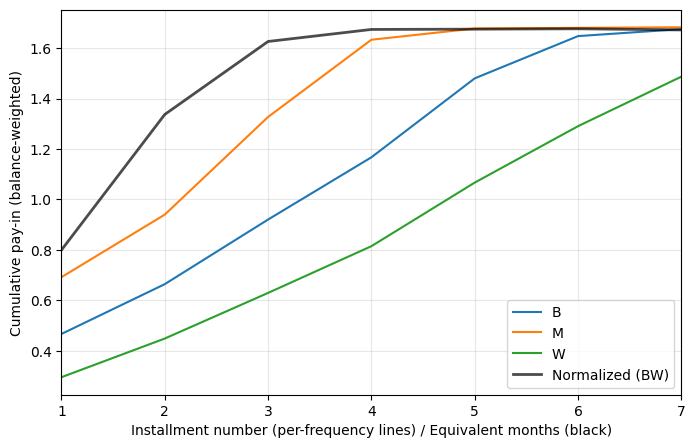

In [13]:
CAP = 1.75

# Reuse existing data/params
CAP_LOCAL = CAP if 'CAP' in globals() else 1.75  # cap pay-in ratio
df_src = latest  # or switch to another df you've already prepared

use = ["LoanID","OriginatedAmount","InstallmentNumber","PaidOffPaymentAmount","Frequency"]
sub = (df_src[use]
       .dropna(subset=["LoanID","OriginatedAmount","InstallmentNumber","Frequency"])
       .copy())
sub["InstallmentNumber"] = sub["InstallmentNumber"].astype(int)
sub["PaidOffPaymentAmount"] = sub["PaidOffPaymentAmount"].fillna(0.0)

# Sum multiple payments within the same installment
paid = (sub.groupby(["LoanID","InstallmentNumber"], as_index=False)
          .agg(PaidPerInstall=("PaidOffPaymentAmount","sum")))

# Loan meta
meta = (sub.groupby("LoanID", as_index=False)
          .agg(OriginatedAmount=("OriginatedAmount","first"),
               Frequency=("Frequency","first")))

# Build per-loan cumulative pay-in by installment
rows = []
for loan_id, g in paid.groupby("LoanID"):
    oa = float(meta.loc[meta["LoanID"]==loan_id, "OriginatedAmount"].iloc[0])
    k_max = int(g["InstallmentNumber"].max())
    # fill missing installments with 0 payment
    full = (pd.DataFrame({"InstallmentNumber": np.arange(1, k_max+1)})
              .merge(g, on="InstallmentNumber", how="left")
              .fillna({"PaidPerInstall": 0.0}))
    full["CumPaid"] = full["PaidPerInstall"].cumsum()
    full["CumPayin"] = (full["CumPaid"] / oa).clip(upper=CAP_LOCAL)
    full["StepPayin"] = (full["PaidPerInstall"] / oa).clip(lower=0.0, upper=CAP_LOCAL)
    full["LoanID"] = loan_id
    full["OriginatedAmount"] = oa
    rows.append(full[["LoanID","InstallmentNumber","CumPayin","StepPayin","OriginatedAmount"]])

per_loan_curve = pd.concat(rows, ignore_index=True)
per_loan_curve = per_loan_curve.merge(meta[["LoanID","Frequency"]], on="LoanID", how="left")
# Combine MB & ME into unified monthly frequency 'M'
per_loan_curve["FrequencyNorm"] = per_loan_curve["Frequency"].replace({"MB":"M","ME":"M"})

# Pool curves overall (x = installment number) — avoid groupby.apply deprecation
_tmp = (per_loan_curve
          .assign(
              w=per_loan_curve["OriginatedAmount"],
              wCum=per_loan_curve["CumPayin"] * per_loan_curve["OriginatedAmount"],
              wStep=per_loan_curve["StepPayin"] * per_loan_curve["OriginatedAmount"])
       )
curve_bw = (_tmp.groupby("InstallmentNumber", as_index=False)
              .agg(wCum=("wCum","sum"), wStep=("wStep","sum"), w=("w","sum")))
curve_bw["CumPayin_BW"] = curve_bw["wCum"] / curve_bw["w"]
curve_bw["StepPayin_BW"] = curve_bw["wStep"] / curve_bw["w"]
curve_bw = curve_bw[["InstallmentNumber","CumPayin_BW","StepPayin_BW"]]

curve_ew = (per_loan_curve.groupby("InstallmentNumber", as_index=False)
              .agg(CumPayin_EW=("CumPayin","mean"),
                   StepPayin_EW=("StepPayin","mean")))
curve_inst = (curve_bw.merge(curve_ew, on="InstallmentNumber", how="outer")
                      .sort_values("InstallmentNumber"))

# Per-frequency balance-weighted curves (no apply) — using unified FrequencyNorm
_tmp_freq = (per_loan_curve
               .assign(
                   w=per_loan_curve["OriginatedAmount"],
                   wCum=per_loan_curve["CumPayin"] * per_loan_curve["OriginatedAmount"])
            )
curve_bw_freq = (_tmp_freq.groupby(["FrequencyNorm","InstallmentNumber"], as_index=False)
                   .agg(wCum=("wCum","sum"), w=("w","sum")))
curve_bw_freq["CumPayin_BW"] = curve_bw_freq["wCum"] / curve_bw_freq["w"]
curve_bw_freq = curve_bw_freq[["FrequencyNorm","InstallmentNumber","CumPayin_BW"]]

# Cross-frequency normalization (map installments to equivalent months)
ppy_map = {"B": 26, "W": 52, "MB": 12, "ME": 12}

per_loan_curve["ppy"] = per_loan_curve["Frequency"].map(ppy_map)
per_loan_curve = per_loan_curve[per_loan_curve["ppy"].notna()].copy()

per_loan_curve["k_month"] = np.round(
    per_loan_curve["InstallmentNumber"] * (12.0 / per_loan_curve["ppy"])
).astype(int)

# Pool on normalized axis (equivalent months) — avoid groupby.apply deprecation
_tmp_norm = (per_loan_curve
               .assign(
                   w=per_loan_curve["OriginatedAmount"],
                   wCum=per_loan_curve["CumPayin"] * per_loan_curve["OriginatedAmount"])
            )
curve_norm_bw = (_tmp_norm.groupby("k_month", as_index=False)
                   .agg(wCum=("wCum","sum"), w=("w","sum")))
curve_norm_bw["CumPayin_BW"] = curve_norm_bw["wCum"] / curve_norm_bw["w"]
curve_norm_bw = curve_norm_bw[["k_month","CumPayin_BW"]]

curve_norm_ew = (per_loan_curve.groupby("k_month", as_index=False)
                   .agg(CumPayin_EW=("CumPayin","mean")))

curve_norm = (curve_norm_bw.merge(curve_norm_ew, on="k_month", how="outer")
                         .sort_values("k_month"))

# Determine x-axis cap from means of per-loan Kmax by normalized frequency
_kmax = (df_src.groupby(["Frequency","LoanID"], as_index=False)
           .agg(Kmax=("InstallmentNumber","max")))
_kmax["FrequencyNorm"] = _kmax["Frequency"].replace({"MB":"M","ME":"M"})
cap_x = int(np.ceil(_kmax.groupby("FrequencyNorm")["Kmax"].mean().max()))

# Multicolored per-frequency (raw installments) + normalized overall line
fig, ax = plt.subplots(figsize=(8,5))
for f, g in curve_bw_freq.groupby("FrequencyNorm"):
    gg = g[g["InstallmentNumber"] <= cap_x]
    ax.plot(gg["InstallmentNumber"], gg["CumPayin_BW"], label=f)

# Also cap normalized x to equivalent months <= cap_x (for visual consistency)
ax.plot(curve_norm.loc[curve_norm["k_month"] <= cap_x, "k_month"],
        curve_norm.loc[curve_norm["k_month"] <= cap_x, "CumPayin_BW"],
        color="k", lw=2, alpha=0.7, label="Normalized (BW)")

ax.set_xlim(1, cap_x)
ax.set_xlabel("Installment number (per-frequency lines) / Equivalent months (black)")
ax.set_ylabel("Cumulative pay-in (balance-weighted)")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

In [10]:
# Inspect loans with InstallmentNumber > 10

import numpy as np
import pandas as pd

# Overview
kmax = per_loan_curve["InstallmentNumber"].max()
loans_kmax = (per_loan_curve.groupby("LoanID")["InstallmentNumber"]
              .max().rename("Kmax").reset_index())
n_gt10 = int((loans_kmax["Kmax"] > 10).sum())
print(f"Max InstallmentNumber overall: {kmax}")
print(f"Loans with Kmax > 10: {n_gt10} / {loans_kmax.shape[0]}")

# Frequencies represented beyond k>10 (sanity check)
if "Frequency" in per_loan_curve.columns:
    print("\nFrequency distribution for k > 10 (per_loan_curve):")
    print(per_loan_curve.loc[per_loan_curve["InstallmentNumber"] > 10]
          .groupby("Frequency").size())

# Pick a few example loans
sample_loans = loans_kmax.loc[loans_kmax["Kmax"] > 10, "LoanID"].head(3).tolist()
print("\nSample loans:", sample_loans)

for loan in sample_loans:
    meta_row = per_loan_curve.loc[per_loan_curve["LoanID"]==loan, ["OriginatedAmount","Frequency"]].head(1)
    oa = float(meta_row["OriginatedAmount"].iloc[0]) if len(meta_row) else np.nan
    freq = str(meta_row["Frequency"].iloc[0]) if "Frequency" in meta_row.columns and len(meta_row) else "NA"
    print(f"\nLoan {loan} | OA={oa:,.2f} | Freq={freq}")

    # Computed per-loan curve (post-aggregation and fill)
    pl = per_loan_curve[per_loan_curve["LoanID"]==loan].sort_values("InstallmentNumber")
    print("Computed per-loan curve (k=8..15):")
    display(pl.loc[(pl["InstallmentNumber"]>=8) & (pl["InstallmentNumber"]<=15),
                   ["InstallmentNumber","StepPayin","CumPayin"]])

    # Aggregated raw payments by installment (pre-cumsum), if available
    if "paid" in globals():
        raw = paid[paid["LoanID"]==loan].sort_values("InstallmentNumber")
        print("Raw aggregated PaidPerInstall (k=8..15):")
        display(raw.loc[(raw["InstallmentNumber"]>=8) & (raw["InstallmentNumber"]<=15)])

    # Original source rows for those installments (if available)
    if "df_src" in globals():
        cols = [c for c in ["LoanID","TransactionDate","Days_Since_Orig","InstallmentNumber",
                            "PaidOffPaymentAmount","Frequency"]
                if c in df_src.columns]
        raw_src = df_src[df_src["LoanID"]==loan].sort_values(
            ["InstallmentNumber"] + (["TransactionDate"] if "TransactionDate" in df_src.columns else [])
        )
        print("Underlying source rows (k=8..15):")
        display(raw_src.loc[raw_src["InstallmentNumber"].between(8,15), cols].head(50))

NameError: name 'per_loan_curve' is not defined

C:\Users\axu\AppData\Local\Temp\ipykernel_24936\1624655837.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({"PayinRatio": float(np.average(d["PayinRatio"], weights=d["OriginatedAmount"]))}))
C:\Users\axu\AppData\Local\Temp\ipykernel_24936\1624655837.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({"PayinRatio": float(np.average(d["PayinRatio"], weights=d

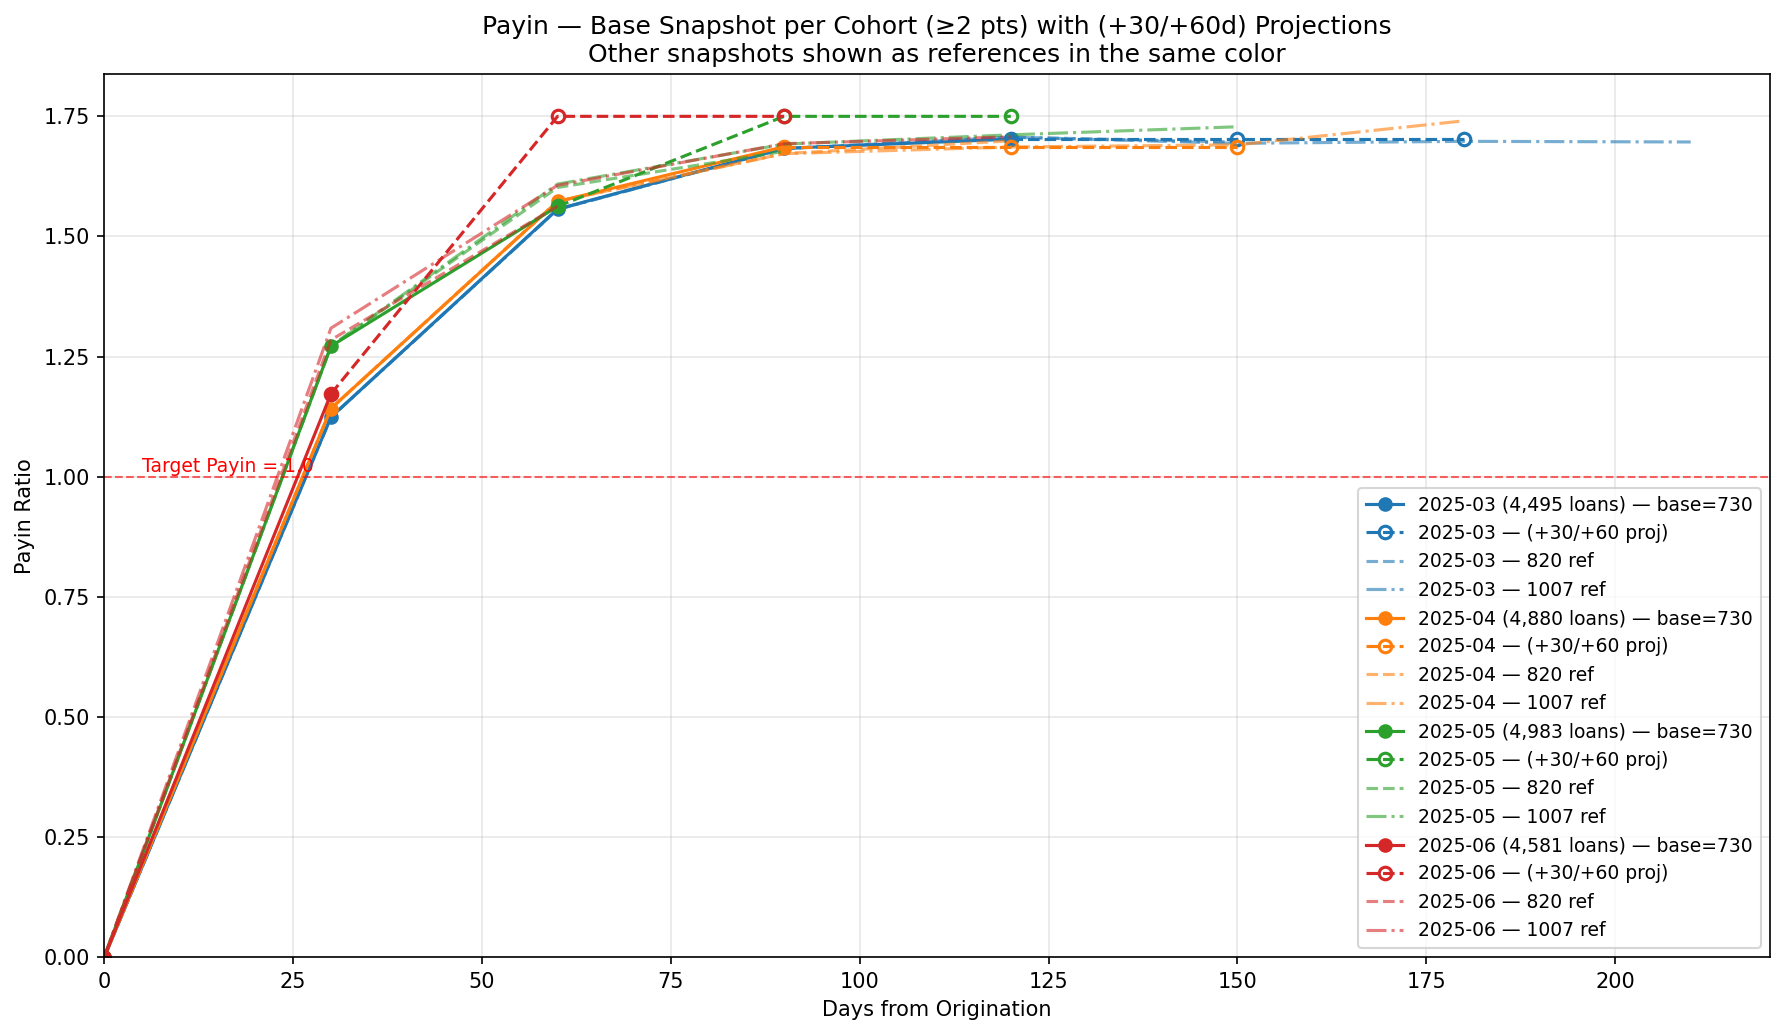

In [95]:
# plot_multi_cohorts_base_fallback.py
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_730  = Path("yieldcurvedata_730.csv")
DATA_820  = Path("yieldcurvedata_820.csv")
DATA_1007 = Path("yieldcurvedata_1007.csv")

COHORTS     = ["2025-03","2025-04", "2025-05","2025-06"]      # cohorts to show
DAY_GRID    = np.array([0,30,60,90,120,150,180,210])
PROJ_STEPS  = (30,60)
CAP         = 1.75
TARGET_LINE = 1.0
METHOD      = "logistic"                  # or "linear"
FIG_PATH    = Path("payin_multi_base_fallback.png")

# ---------- load & reduce ----------
def load_df(path: Path) -> pd.DataFrame:
    use = ["LoanID","OrigYear","OrigMonth","OriginatedAmount","Days_Since_Orig","PaidOffPaymentAmount"]
    df = pd.read_csv(path, usecols=use, low_memory=False).dropna(subset=["LoanID","OriginatedAmount","Days_Since_Orig"])
    df["Days_Since_Orig"] = df["Days_Since_Orig"].astype(int)
    df["PaidOffPaymentAmount"] = df["PaidOffPaymentAmount"].fillna(0.0)
    df["Cohort"] = df["OrigYear"].astype(int).astype(str) + "-" + df["OrigMonth"].astype(int).astype(str).str.zfill(2)
    return df

def cohort_curve(df: pd.DataFrame, cohort: str, grid=DAY_GRID) -> tuple[pd.DataFrame, int]:
    sub = df[df["Cohort"]==cohort].copy()
    if sub.empty: return pd.DataFrame(columns=["Days","PayinRatio"]), 0
    loans = sub["LoanID"].nunique()
    g = (sub.groupby(["LoanID","Days_Since_Orig"], as_index=False)
           .agg(PaidDay=("PaidOffPaymentAmount","sum"),
                OriginatedAmount=("OriginatedAmount","first"))
           .sort_values(["LoanID","Days_Since_Orig"]))
    g["CumPaid"] = g.groupby("LoanID", sort=False)["PaidDay"].cumsum()
    g["PayinRatio"] = (g["CumPaid"]/g["OriginatedAmount"]).clip(upper=CAP)

    idx = np.searchsorted(grid, g["Days_Since_Orig"].values, side="right") - 1
    idx = np.clip(idx, 0, len(grid)-1)
    g["GridDay"] = grid[idx]

    last = (g.groupby(["LoanID","GridDay"], as_index=False)
              .agg(PayinRatio=("PayinRatio","max"),
                   OriginatedAmount=("OriginatedAmount","first")))
    curve = (last.groupby("GridDay", as_index=False)
               .apply(lambda d: pd.Series({"PayinRatio": float(np.average(d["PayinRatio"], weights=d["OriginatedAmount"]))}))
               .reset_index()
               .rename(columns={"GridDay":"Days"}))

    # Ensure (0,0) anchor exists
    if 0 not in curve["Days"].values:
        curve = pd.concat([pd.DataFrame({"Days":[0], "PayinRatio":[0.0]}), curve], ignore_index=True)
    else:
        curve.loc[curve["Days"]==0, "PayinRatio"] = 0.0

    return curve.sort_values("Days").reset_index(drop=True), loans

# ---------- projections ----------
def recent_linear_projection(x, y, steps=PROJ_STEPS, window=20, cap=CAP):
    x = np.asarray(x, float); y = np.asarray(y, float)
    if x.size < 2: return {}
    ux, idx = np.unique(x, return_index=True); x, y = ux, y[idx]
    use = max(2, min(window, x.size))
    xs, ys = x[-use:], y[-use:]
    A = np.vstack([xs, np.ones_like(xs)]).T
    slope, _ = np.linalg.lstsq(A, ys, rcond=None)[0]
    last_x, last_y = x[-1], y[-1]
    return {int(last_x+h): float(min(cap, max(last_y, last_y + slope*h))) for h in steps}

def logistic_projection(x, y, steps=PROJ_STEPS, cap=CAP):
    try:
        from scipy.optimize import curve_fit
    except Exception:
        return recent_linear_projection(x, y, steps, cap=cap)
    def _sig(xx, L, k, x0): return L/(1+np.exp(-k*(xx-x0)))
    x = np.asarray(x, float); y = np.asarray(y, float)
    if x.size < 4:
        return recent_linear_projection(x, y, steps, cap=cap)
    L0 = max(float(y.max()), 1.2); k0 = 0.03; x00 = np.median(x)
    bounds = ([1.0, 1e-4, 0.0], [CAP, 1.0, 730.0])
    try:
        (L,k,x0), _ = curve_fit(_sig, x, y, p0=[L0,k0,x00], bounds=bounds, maxfev=10000)
        last_x, last_y = x[-1], y[-1]
        return {int(last_x+h): float(min(CAP, max(last_y, float(_sig(last_x+h, L, k, x0))))) for h in steps}
    except Exception:
        return recent_linear_projection(x, y, steps, cap=cap)

def project_from_curve(curve_df: pd.DataFrame, method="logistic"):
    curve_df = curve_df.sort_values("Days")
    x = curve_df["Days"].values; y = curve_df["PayinRatio"].values
    return logistic_projection(x, y) if method=="logistic" else recent_linear_projection(x, y)

# ---------- plotting with base fallback ----------
def pick_base_curve(c730, c820, c1007, min_pts=2):
    """Return (name, df) choosing the first curve with >= min_pts."""
    for name, cur in [("730", c730), ("820", c820), ("1007", c1007)]:
        if len(cur.dropna()) and cur["Days"].nunique() >= min_pts:
            return name, cur.sort_values("Days")
    return "730", c730.sort_values("Days")

df730, df820, df1007 = load_df(DATA_730), load_df(DATA_820), load_df(DATA_1007)

plt.figure(figsize=(12,7), dpi=150)
ax = plt.gca()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, cohort in enumerate(COHORTS):
    color = colors[i % len(colors)]

    c730, n_loans = cohort_curve(df730, cohort)
    c820, _ = cohort_curve(df820, cohort)
    c1007,_ = cohort_curve(df1007, cohort)

    base_name, base_df = pick_base_curve(c730, c820, c1007, min_pts=2)

    # base observed (solid, filled markers)
    ax.plot(base_df["Days"], base_df["PayinRatio"],
            color=color, linestyle="-", marker="o", mfc=color, mec=color,
            label=f"{cohort} ({n_loans:,} loans) — base={base_name}")

    # projections (+30/+60) from base curve last point (hollow markers + dashed)
    proj = project_from_curve(base_df, method=METHOD)
    if proj:
        last_d = int(base_df["Days"].iloc[-1])
        last_y = float(base_df["PayinRatio"].iloc[-1])
        xs = [last_d] + sorted(proj)
        ys = [last_y] + [proj[k] for k in sorted(proj)]
        ax.plot(xs, ys, color=color, linestyle="--", marker="o", mfc="none", mec=color, mew=1.5,
                label=f"{cohort} — (+30/+60 proj)")

    # show the other snapshots (same color, different styles)
    if base_name != "730" and not c730.empty:
        ax.plot(c730["Days"], c730["PayinRatio"], color=color, linestyle=":", linewidth=1.5, alpha=0.6,
                label=f"{cohort} — 730 ref")
    if base_name != "820" and not c820.empty:
        ax.plot(c820["Days"], c820["PayinRatio"], color=color, linestyle="--", linewidth=1.5, alpha=0.6,
                label=f"{cohort} — 820 ref")
    if base_name != "1007" and not c1007.empty:
        ax.plot(c1007["Days"], c1007["PayinRatio"], color=color, linestyle="-.", linewidth=1.5, alpha=0.6,
                label=f"{cohort} — 1007 ref")

# axes from origin
ax.set_xlim(left=0); ax.set_ylim(bottom=0.0)
ax.axhline(TARGET_LINE, linestyle="--", linewidth=1, color="red", alpha=0.6)
ax.text(5, TARGET_LINE+0.01, f"Target Payin = {TARGET_LINE:.1f}", color="red", fontsize=9)

ax.set_title("Payin — Base Snapshot per Cohort (≥2 pts) with (+30/+60d) Projections\n"
             "Other snapshots shown as references in the same color")
ax.set_xlabel("Days from Origination")
ax.set_ylabel("Payin Ratio")
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right", fontsize=9)
plt.tight_layout()

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# --------------------------------------------------------------------------------------
# Expected input for the base snapshot (df_base):
#   columns: ['LoanID','Cohort','OriginationDate','SnapshotDate','PayinRatio']
#     - OriginationDate, SnapshotDate: parsable to datetime
#     - Cohort: string like '2025-06' (year-month) or any label you use per cohort
#
# Optional reference snapshots (refs): dict(label -> DataFrame in same format as df_base)
#   e.g., refs = {
#       "820": df_820,     # snapshot taken on 8/20
#       "1007": df_1007,   # snapshot taken on 10/07
#   }
#
# Notes:
# - Uses TRUE days since each loan’s OriginDate: days_since_orig = SnapshotDate - OriginationDate
# - Aggregates by exact days; you can bin by 5 days by toggling BIN_DAYS > 1.
# - Projection is linear from the last two observed points; capped to MAX_PAYIN.
# --------------------------------------------------------------------------------------

BIN_DAYS   = 1      # change to 5 or 7 if you want smoother curves
MAX_PAYIN  = 1.75   # safety cap you mentioned before
PROJ_OFFSETS = [30, 60]  # +30/+60 days projections

def _prepare(df: pd.DataFrame, label: str) -> pd.DataFrame:
    d = df.copy()
    d["OriginationDate"] = pd.to_datetime(d["OriginationDate"])
    d["SnapshotDate"]    = pd.to_datetime(d["SnapshotDate"])
    d["days_since_orig"] = (d["SnapshotDate"] - d["OriginationDate"]).dt.days
    if BIN_DAYS > 1:
        d["day_key"] = (d["days_since_orig"] // BIN_DAYS) * BIN_DAYS
    else:
        d["day_key"] = d["days_since_orig"]

    # Aggregate to a single series per cohort & day
    agg = (
        d.groupby(["Cohort", "day_key"], as_index=False)
         .agg(PayinRatio=("PayinRatio", "mean"),
              loan_count=("LoanID", "nunique"))
    )
    agg["snapshot_label"] = label
    return agg

def _project_from_tail(x: np.ndarray, y: np.ndarray, add_days=PROJ_OFFSETS):
    """
    Linear projection using the last two observed points.
    Returns arrays (x_proj, y_proj).
    """
    if len(x) < 2:
        return np.array([]), np.array([])
    x1, x2 = x[-2], x[-1]
    y1, y2 = y[-2], y[-1]
    if x2 == x1:
        return np.array([]), np.array([])

    slope = (y2 - y1) / (x2 - x1)
    x_proj = np.array([x2 + d for d in add_days], dtype=float)
    y_proj = y2 + slope * (x_proj - x2)
    y_proj = np.clip(y_proj, 0, MAX_PAYIN)
    return x_proj, y_proj

def plot_payin_curves_with_true_origin(
    df_base: pd.DataFrame,
    refs: dict[str, pd.DataFrame] | None = None,
    title: str = "Payin — Base Snapshot per Cohort (true origination) with (+30/+60) Projections",
    target_payin: float | None = 1.0,
    figsize=(14,8)
):
    base_label = "base"
    base = _prepare(df_base, base_label)

    ref_curves = {}
    if refs:
        for lbl, df_ref in refs.items():
            ref_curves[lbl] = _prepare(df_ref, lbl)

    # Collect unique cohorts to keep colors consistent across base & refs
    cohorts = sorted(base["Cohort"].unique())
    # Build a color cycle keyed by cohort
    color_map = {}
    for i, c in enumerate(cohorts):
        color_map[c] = f"C{i % 10}"

    fig, ax = plt.subplots(figsize=figsize)

    legend_items = []

    # Plot per cohort
    for cohort in cohorts:
        # ---------- Base curve ----------
        g = base[base["Cohort"] == cohort].sort_values("day_key")
        x = g["day_key"].to_numpy()
        y = g["PayinRatio"].to_numpy()
        clr = color_map[cohort]

        if len(x) == 0:
            continue

        # solid line with markers
        ax.plot(x, y, marker="o", linewidth=2, color=clr,
                label=f"{cohort} — base")

        # (+30/+60) projection from last two observed points
        x_proj, y_proj = _project_from_tail(x, y, PROJ_OFFSETS)
        if x_proj.size > 0:
            ax.plot([x[-1], *x_proj], [y[-1], *y_proj],
                    linestyle="--", linewidth=2, color=clr,
                    label=f"{cohort} — (+30/+60) proj")
            ax.scatter(x_proj, y_proj, facecolors="none", edgecolors=clr)

        # ---------- Reference snapshots (same color, lighter/dashed) ----------
        for ref_label, ref_df in ref_curves.items():
            r = ref_df[ref_df["Cohort"] == cohort].sort_values("day_key")
            if r.empty:
                continue
            xr = r["day_key"].to_numpy()
            yr = r["PayinRatio"].to_numpy()
            style = ":" if ref_label == "1007" else "--"
            ax.plot(xr, yr, linestyle=style, linewidth=2, color=clr,
                    label=f"{cohort} — {ref_label} ref")

    # Target payin line
    if target_payin is not None:
        ax.axhline(target_payin, linestyle="--", linewidth=1.2, color="red")
        ax.text(0, target_payin + 0.02, f"Target Payin = {target_payin}",
                color="red")

    ax.set_xlabel("Days from Origination", fontsize=11)
    ax.set_ylabel("Payin Ratio", fontsize=11)
    ax.set_title(title, fontsize=14)
    ax.grid(True, alpha=0.25)
    ax.legend(ncol=1, fontsize=9)
    plt.tight_layout()
    plt.show()


# --------------------------------------------------------------------------------------
# Example usage
df_base = pd.read_csv("yieldcurvedata_730.csv")
df_820  = pd.read_csv("yieldcurvedata_820.csv")
df_1007 = pd.read_csv("yieldcurvedata_1007.csv")  

plot_payin_curves_with_true_origin(
    df_base,
    refs={"820": df_820, "1007": df_1007},   # or None if you don't have refs
    title="Payin — Base Snapshot per Cohort (≥2 pts) with (+30/+60d) Projections\nOther snapshots shown as references in the same color",
    target_payin=1.0
)
# --------------------------------------------------------------------------------------


KeyError: 'SnapshotDate'

C:\Users\axu\AppData\Local\Temp\ipykernel_24936\157891688.py:101: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({
C:\Users\axu\AppData\Local\Temp\ipykernel_24936\157891688.py:101: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({
C:\Users\axu\AppData\Local\Temp\ipykernel_24936\157891688.py:101: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. 

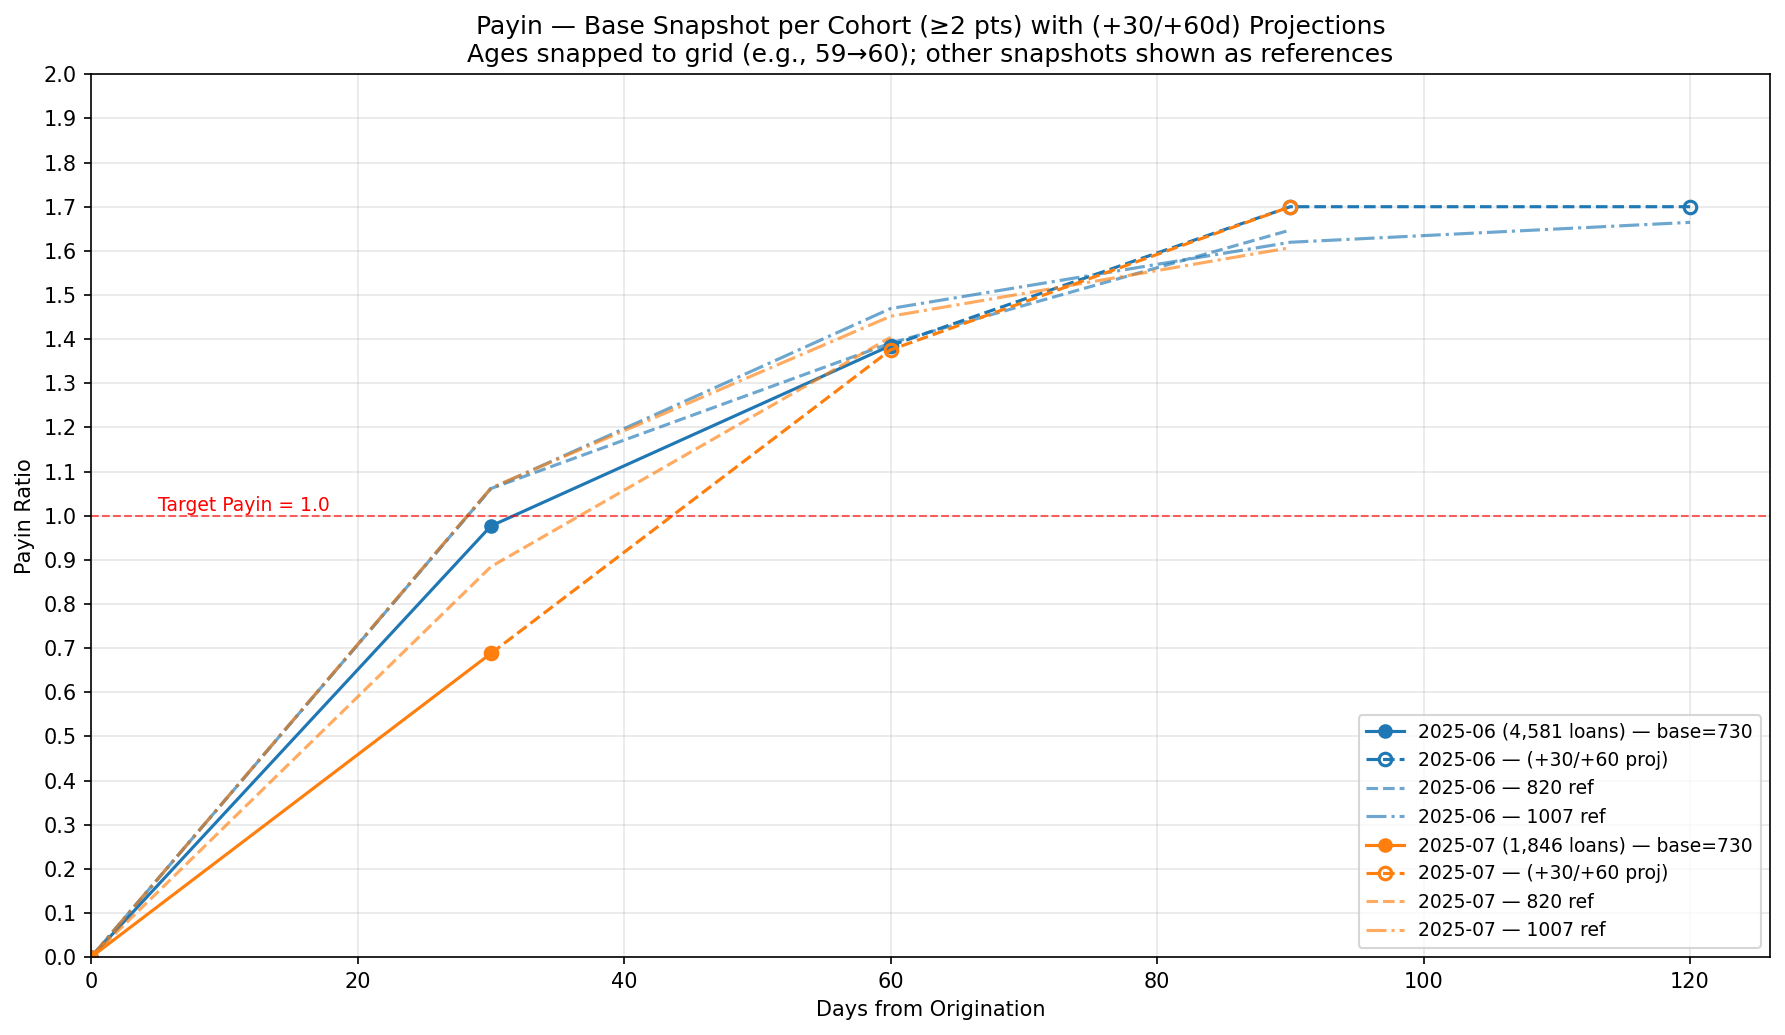

In [100]:
# payin_pipeline.py
# Complete pipeline: build cohort curves, snap to grid (~59->60), pick base snapshot, make +30/+60 projections,
# and plot multi-cohort chart with cohort-colored 730/base/820/1007 series.

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============== Config ==============
DATA_730  = Path("yieldcurvedata_730.csv")
DATA_820  = Path("yieldcurvedata_820.csv")
DATA_1007 = Path("yieldcurvedata_1007.csv")

COHORTS      = ["2025-06", "2025-07"]        # cohorts to show
DAY_GRID     = np.array([0, 30, 60, 90, 120, 150, 180, 210])
SNAP_MODE    = "nearest"                     # "nearest"  (e.g., 59 -> 60), or "floor" with tol, or "ceil"
SNAP_TOL     = None                          # use e.g. 2 if SNAP_MODE == "floor" and you want 58/59->60
CAP          = 1.7                          # cap payin ratio
TARGET_LINE  = 1.0
PROJ_STEPS   = (30, 60)                      # project two dots
PROJ_METHOD  = "logistic"                    # "logistic" or "linear"
MIN_BASE_PTS = 2                             # base snapshot must have >= this many points

OUT_DIR  = Path("payin_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_PATH = OUT_DIR / "payin_multi_pipeline.png"
CSV_PATH = OUT_DIR / "payin_multi_pipeline_projection_points.csv"


# ============== Utilities ==============
def snap_to_grid(days, grid, mode="nearest", tol=None):
    """
    Map raw ages (days) to grid days.
      mode="floor"   -> last grid <= day
      mode="nearest" -> nearest grid day (e.g., 59->60)
      mode="ceil"    -> first grid >= day
    tol: if provided with floor, bump to the next grid when (next-grid - day) <= tol.
    """
    days = np.asarray(days, dtype=float)
    grid = np.asarray(grid, dtype=float)

    if mode == "nearest":
        idx = np.abs(days[:, None] - grid[None, :]).argmin(axis=1)
    elif mode == "ceil":
        idx = np.searchsorted(grid, days, side="left")
    else:  # floor (original), optional tolerance
        idx = np.searchsorted(grid, days, side="right") - 1
        if tol is not None:
            next_idx = np.clip(idx + 1, 0, len(grid) - 1)
            bump = (grid[next_idx] - days) <= tol
            idx = np.where(bump, next_idx, idx)

    idx = np.clip(idx, 0, len(grid) - 1)
    return grid[idx].astype(int)


# ============== Data loading & reduction ==============
def load_df(path: Path) -> pd.DataFrame:
    use = ["LoanID", "OrigYear", "OrigMonth", "OriginatedAmount", "Days_Since_Orig", "PaidOffPaymentAmount"]
    df = pd.read_csv(path, usecols=use, low_memory=False).dropna(subset=["LoanID", "OriginatedAmount", "Days_Since_Orig"])
    df["Days_Since_Orig"] = df["Days_Since_Orig"].astype(int)
    df["PaidOffPaymentAmount"] = df["PaidOffPaymentAmount"].fillna(0.0)
    df["Cohort"] = df["OrigYear"].astype(int).astype(str) + "-" + df["OrigMonth"].astype(int).astype(str).str.zfill(2)
    return df


def cohort_curve(df: pd.DataFrame, cohort: str, grid=DAY_GRID,
                 snap_mode=SNAP_MODE, snap_tol=SNAP_TOL, cap=CAP) -> tuple[pd.DataFrame, int]:
    """
    Build a cohort curve on the grid:
      - per-loan daily flows → cumulative → payin ratio (capped)
      - snap ages to grid (nearest/floor/ceil)
      - weighted average by originated amount
      - force (0,0) anchor
    Returns: (curve_df with cols Days, PayinRatio, loan_count)
    """
    sub = df[df["Cohort"] == cohort].copy()
    if sub.empty:
        return pd.DataFrame(columns=["Days", "PayinRatio"]), 0

    loan_cnt = sub["LoanID"].nunique()

    # Per-loan per-day flows
    g = (sub.groupby(["LoanID", "Days_Since_Orig"], as_index=False)
           .agg(PaidDay=("PaidOffPaymentAmount", "sum"),
                OriginatedAmount=("OriginatedAmount", "first"))
           .sort_values(["LoanID", "Days_Since_Orig"]))
    # Cumulative & ratio
    g["CumPaid"] = g.groupby("LoanID", sort=False)["PaidDay"].cumsum()
    g["PayinRatio"] = (g["CumPaid"] / g["OriginatedAmount"]).clip(upper=cap)

    # Snap to grid
    g["GridDay"] = snap_to_grid(g["Days_Since_Orig"].values, grid, mode=snap_mode, tol=snap_tol)

    # Last value per (loan, grid) then weighted pool to cohort
    last = (g.groupby(["LoanID", "GridDay"], as_index=False)
              .agg(PayinRatio=("PayinRatio", "max"),
                   OriginatedAmount=("OriginatedAmount", "first")))
    curve = (last.groupby("GridDay", as_index=False)
               .apply(lambda d: pd.Series({
                   "PayinRatio": float(np.average(d["PayinRatio"], weights=d["OriginatedAmount"]))
               }))
               .reset_index()
               .rename(columns={"GridDay": "Days"}))

    # Ensure (0,0) anchor
    if 0 not in curve["Days"].values:
        curve = pd.concat([pd.DataFrame({"Days": [0], "PayinRatio": [0.0]}), curve], ignore_index=True)
    else:
        curve.loc[curve["Days"] == 0, "PayinRatio"] = 0.0

    return curve.sort_values("Days").reset_index(drop=True), loan_cnt


# ============== Projections ==============
def recent_linear_projection(x, y, steps=PROJ_STEPS, window=20, cap=CAP):
    x = np.asarray(x, float); y = np.asarray(y, float)
    if x.size < 2: return {}
    ux, idx = np.unique(x, return_index=True); x, y = ux, y[idx]
    use = max(2, min(window, x.size))
    xs, ys = x[-use:], y[-use:]
    A = np.vstack([xs, np.ones_like(xs)]).T
    slope, _ = np.linalg.lstsq(A, ys, rcond=None)[0]
    last_x, last_y = x[-1], y[-1]
    return {int(last_x + h): float(min(cap, max(last_y, last_y + slope * h))) for h in steps}


def logistic_projection(x, y, steps=PROJ_STEPS, cap=CAP):
    try:
        from scipy.optimize import curve_fit
    except Exception:
        return recent_linear_projection(x, y, steps, cap=cap)

    def _sig(xx, L, k, x0): return L / (1 + np.exp(-k * (xx - x0)))
    x = np.asarray(x, float); y = np.asarray(y, float)
    if x.size < 4:
        return recent_linear_projection(x, y, steps, cap=cap)

    L0 = max(float(y.max()), 1.2); k0 = 0.03; x00 = np.median(x)
    bounds = ([1.0, 1e-4, 0.0], [CAP, 1.0, 730.0])
    try:
        (L, k, x0), _ = curve_fit(_sig, x, y, p0=[L0, k0, x00], bounds=bounds, maxfev=10000)
        last_x, last_y = x[-1], y[-1]
        out = {}
        for h in steps:
            yy = float(_sig(last_x + h, L, k, x0))
            out[int(last_x + h)] = float(min(CAP, max(last_y, yy)))
        return out
    except Exception:
        return recent_linear_projection(x, y, steps, cap=cap)


def project_from_curve(curve_df: pd.DataFrame, method=PROJ_METHOD):
    curve_df = curve_df.sort_values("Days")
    x = curve_df["Days"].values; y = curve_df["PayinRatio"].values
    return logistic_projection(x, y) if method == "logistic" else recent_linear_projection(x, y)


# ============== Base snapshot selection ==============
def pick_base_curve(c730, c820, c1007, min_pts=MIN_BASE_PTS):
    """Choose first snapshot with >= min_pts unique Days."""
    for name, cur in [("730", c730), ("820", c820), ("1007", c1007)]:
        if not cur.empty and cur["Days"].nunique() >= min_pts:
            return name, cur.sort_values("Days")
    # fallback
    return "730", c730.sort_values("Days")


# ============== Main build & plot ==============
def main():
    df730, df820, df1007 = load_df(DATA_730), load_df(DATA_820), load_df(DATA_1007)

    # colors
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # collect projection points for CSV
    proj_rows = []

    plt.figure(figsize=(12, 7), dpi=150)
    ax = plt.gca()

    for i, cohort in enumerate(COHORTS):
        color = colors[i % len(colors)]

        c730, n_loans = cohort_curve(df730, cohort)
        c820, _       = cohort_curve(df820, cohort)
        c1007, _      = cohort_curve(df1007, cohort)

        base_name, base_df = pick_base_curve(c730, c820, c1007, min_pts=MIN_BASE_PTS)

        # Base observed series (solid, filled markers)
        ax.plot(base_df["Days"], base_df["PayinRatio"],
                color=color, linestyle="-", marker="o", mfc=color, mec=color,
                label=f"{cohort} ({n_loans:,} loans) — base={base_name}")

        # Projections from base last point (dashed, hollow markers)
        proj = project_from_curve(base_df, method=PROJ_METHOD)
        if proj:
            last_d = int(base_df["Days"].iloc[-1]); last_y = float(base_df["PayinRatio"].iloc[-1])
            xs = [last_d] + sorted(proj); ys = [last_y] + [proj[k] for k in sorted(proj)]
            ax.plot(xs, ys, color=color, linestyle="--", marker="o", mfc="none", mec=color, mew=1.5,
                    label=f"{cohort} — (+30/+60 proj)")

            # stash for CSV
            proj_rows.append({
                "Cohort": cohort, "Base": base_name,
                "Last_Day": last_d, "Last_Payin": round(last_y, 3),
                "+30d": round(proj.get(last_d + 30, np.nan), 3),
                "+60d": round(proj.get(last_d + 60, np.nan), 3)
            })

        # Show other snapshots as references, same color
        if base_name != "730" and not c730.empty:
            ax.plot(c730["Days"], c730["PayinRatio"], color=color, linestyle=":",  linewidth=1.5, alpha=0.65,
                    label=f"{cohort} — 730 ref")
        if base_name != "820" and not c820.empty:
            ax.plot(c820["Days"], c820["PayinRatio"], color=color, linestyle="--", linewidth=1.5, alpha=0.65,
                    label=f"{cohort} — 820 ref")
        if base_name != "1007" and not c1007.empty:
            ax.plot(c1007["Days"], c1007["PayinRatio"], color=color, linestyle="-.", linewidth=1.5, alpha=0.65,
                    label=f"{cohort} — 1007 ref")

    # Axes & cosmetics
    ax.set_xlim(left=0); ax.set_ylim(bottom=0.0);ax.set_yticks(np.arange(0, 2.05, 0.1))
    ax.axhline(TARGET_LINE, linestyle="--", linewidth=1, color="red", alpha=0.6)
    ax.text(5, TARGET_LINE + 0.01, f"Target Payin = {TARGET_LINE:.1f}", color="red", fontsize=9)
    ax.set_title("Payin — Base Snapshot per Cohort (≥2 pts) with (+30/+60d) Projections\n"
                 "Ages snapped to grid (e.g., 59→60); other snapshots shown as references")
    ax.set_xlabel("Days from Origination"); ax.set_ylabel("Payin Ratio")
    ax.grid(True, alpha=0.3); ax.legend(loc="lower right", fontsize=9)
    plt.tight_layout()

    # plt.savefig(FIG_PATH, bbox_inches="tight")

    # # Export projection table
    # pd.DataFrame(proj_rows).to_csv(CSV_PATH, index=False)
    # print(f"Saved figure: {FIG_PATH}")
    # print(f"Saved projections CSV: {CSV_PATH}")


if __name__ == "__main__":
    main()
